## EDSA Traffic Data: Analysis

After an extraction period of 7 days, sufficient data has been collected in order to start munging. Pre-processing will be executed in the following manner:
1. Collate data from raw .csv files
2. Separate aforementioned data into two 2-dimensional numpy arrays (southbound and northbound)
3. Place data in such a way that it is arranged chronologically with respect to the individual lines
4. Take the average for every 4 entries since this represents 1 hour 
The last step is necessary since visualization and line fitting is unhelpful when considering the entire scope of raw data. Breaking the data into several pieces and analysing each set is more conducive for meaningful story telling. As was explained in the previous notebook, polynomial regression is the tool of choice for this task. 

Note that during the 7-day timeframe of data extraction, there was a holiday in the middle of the week. To be more specific, it fell on a Wednesday. This factor will be taken into consideration when analyzing individual days. 

In [9]:
# Use this to analyze extracted data!
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# For Data parsing
import os
import re

runs = 672 # (672/4)
numlines = 37
slashed_runs = runs/4
list_size = numlines * runs

In [10]:
# save all data in numpy arrays
directory = "/Users/kianavillaera/MMDA_Traffic_data/EDSA-Traffic-Analysis-and-Visualization/April29_to_May6"
j = 0 # file number 

list_of_southbound = np.zeros(list_size).reshape(numlines,runs) 
list_of_northbound = np.zeros(list_size).reshape(numlines,runs)

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        f = open(filename)
        f_list = f.readlines()
        i = 0
        for row in f_list:
            if len(row) == 41:
                vol = re.findall("\d",row)
                list_of_southbound[i][j] = vol[0]
                list_of_northbound[i][j] = vol[1]
                i += 1       
        j +=1 
f.close()        

672


In [15]:
# Pre-process the data (take mean of every 4 entries)
print(list_of_southbound[0])
data_southbound = np.mean(list_of_southbound[0].reshape(-1, 4), axis=1)
data_northbound = np.mean(list_of_northbound[0].reshape(-1, 4), axis=1)
print(data_southbound)

[0. 0. 0. 1. 2. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 2. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 2. 0. 0. 1. 0.
 1. 1. 2. 0. 0. 2. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 2.
 0. 0. 1. 0. 0. 2. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 2. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 2. 0. 0. 1. 1. 1. 0. 0.

In [13]:
# Function for data analysis

def analyze(data, runs, bound):
    %matplotlib inline 
    x = range(0,target_runs)
    x = np.array(x)
    data = np.array(data)
    
    p1 = np.polyfit(x,data,1) #order 1
    p2 = np.polyfit(x,data,2) #order 2
    p3 = np.polyfit(x,data,3) #order 3
    plt.style.use('seaborn-whitegrid')
    
    #plot data and linear fit
    plt.plot(x,data,'o')
    plt.plot(x,np.polyval(p1,x),'r-')
    plt.plot(x,np.polyval(p2,x),'g--')
    plt.plot(x,np.polyval(p3,x),'y:') 
    plt.savefig("Polynomial regression of "+ bound +" traffic data.png")
    plt.xlabel("Road")
    plt.ylabel("Volume")
    plt.show()
    
   # print("Slope and intercepts in ascending orders ")
    print(p1)
    print(p2)
    print(p3)

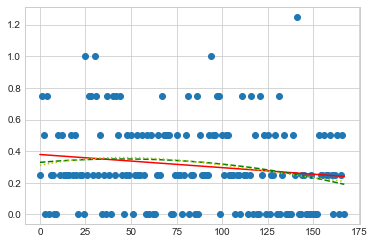

[-0.00083076  0.37889194]
[-1.07528084e-05  9.64962930e-04  3.29210382e-01]
[ 8.25085149e-08 -3.14211914e-05  2.34149374e-03  3.10340149e-01]


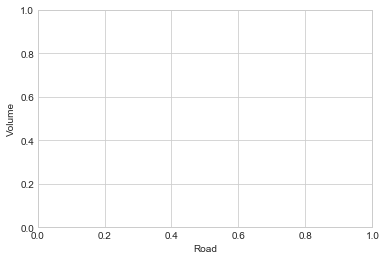

In [14]:
# Loop through both arrays
data = data_southbound
analyze(data, slashed_runs, "South")